In [1]:
# Yelp Reviews Dataset Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import os

In [2]:
# Set plot styling
plt.style.use('ggplot')
sns.set_theme(font_scale=1.2)
sns.set_style("whitegrid")

In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# 1. Load the dataset
print("Loading dataset...")
# Define paths (use relative paths for flexibility)
data_dir = "../data/raw"
# Check if the directory exists, if not create it
os.makedirs(data_dir, exist_ok=True)

# Read the dataset - we'll handle both options: already downloaded or using HF
try:
    # Try to load from local file first
    train_path = os.path.join(data_dir, "train.parquet")
    test_path = os.path.join(data_dir, "test.parquet")
    
    if os.path.exists(train_path) and os.path.exists(test_path):
        train_df = pd.read_parquet(train_path)
        test_df = pd.read_parquet(test_path)
        print("Loaded dataset from local files")
    else:
        # Load from Hugging Face datasets
        print("Loading from Hugging Face datasets...")
        splits = {
            'train': 'yelp_review_full/train-00000-of-00001.parquet', 
            'test': 'yelp_review_full/test-00000-of-00001.parquet'
        }
        train_df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])
        test_df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["test"])
        
        # Save locally for future use
        train_df.to_parquet(train_path)
        test_df.to_parquet(test_path)
        print("Saved dataset to local files for future use")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("If you're having issues with Hugging Face datasets, you may need to:")
    print("1. Install the datasets package: pip install datasets")
    print("2. Login to Hugging Face: huggingface-cli login")
    raise

Loading dataset...
Loading from Hugging Face datasets...
Saved dataset to local files for future use


In [6]:
# 2. Basic Dataset Information
print("\n--- Dataset Information ---")
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Display column names and data types
print("\nColumns and their types:")
print(train_df.dtypes)


--- Dataset Information ---
Train set shape: (650000, 2)
Test set shape: (50000, 2)

Columns and their types:
label     int64
text     object
dtype: object


In [7]:
# 3. Check for missing values
print("\n--- Missing Values ---")
print("Train set missing values:")
print(train_df.isnull().sum())
print("\nTest set missing values:")
print(test_df.isnull().sum())


--- Missing Values ---
Train set missing values:
label    0
text     0
dtype: int64

Test set missing values:
label    0
text     0
dtype: int64



--- Label Values ---
Train set label unique values:
[4 1 3 0 2]

--- Label Distribution ---
Train set label distribution:
label
0    130000
1    130000
2    130000
3    130000
4    130000
Name: count, dtype: int64
Train set label distribution (%): label
0    20.0
1    20.0
2    20.0
3    20.0
4    20.0
Name: count, dtype: float64

Test set label distribution:
label
0    10000
1    10000
2    10000
3    10000
4    10000
Name: count, dtype: int64
Test set label distribution (%): label
0    20.0
1    20.0
2    20.0
3    20.0
4    20.0
Name: count, dtype: float64


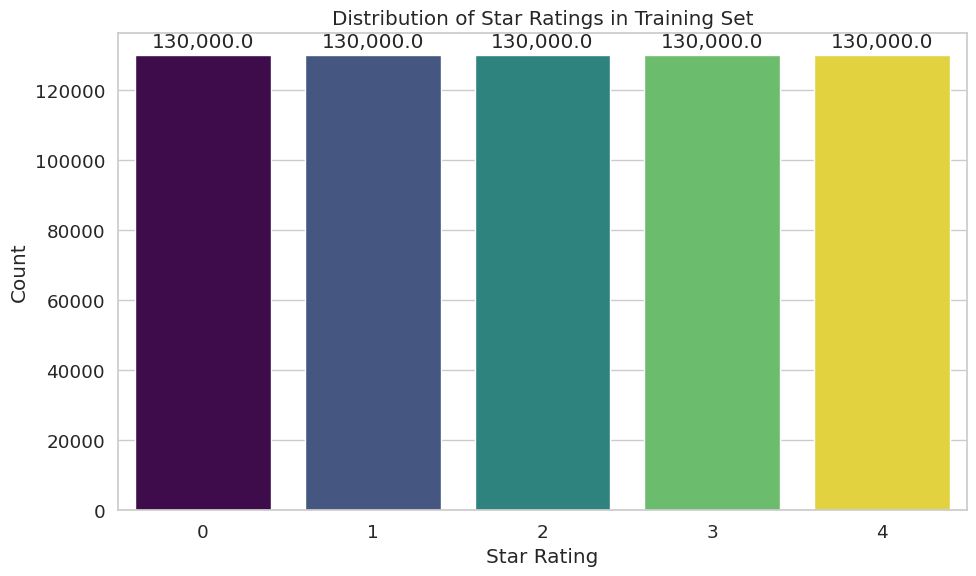

In [11]:
# 4. Data Distribution
print("\n--- Label Values ---")
print("Train set label unique values:")
print(train_df['label'].unique())

print("\n--- Label Distribution ---")
# Original labels are 1-5 stars
print("Train set label distribution:")
train_label_counts = train_df['label'].value_counts().sort_index()
print(train_label_counts)
train_label_distribution = train_label_counts / len(train_df) * 100
print(f"Train set label distribution (%): {train_label_distribution.round(2)}")

print("\nTest set label distribution:")
test_label_counts = test_df['label'].value_counts().sort_index()
print(test_label_counts)
test_label_distribution = test_label_counts / len(test_df) * 100
print(f"Test set label distribution (%): {test_label_distribution.round(2)}")

# Visualize label distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', hue='label', data=train_df, 
                  palette='viridis', legend=False)
plt.title('Distribution of Star Ratings in Training Set')
plt.xlabel('Star Rating')
plt.ylabel('Count')

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.tight_layout()
plt.show()


--- Text Length Analysis ---
Text length statistics (characters):
count    650000.000000
mean        732.325468
std         663.721184
min           1.000000
25%         287.000000
50%         539.000000
75%         957.000000
max        5637.000000
Name: text_length, dtype: float64

Word count statistics:
count    650000.000000
mean        134.098089
std         121.396115
min           1.000000
25%          52.000000
50%          99.000000
75%         175.000000
max        1052.000000
Name: word_count, dtype: float64


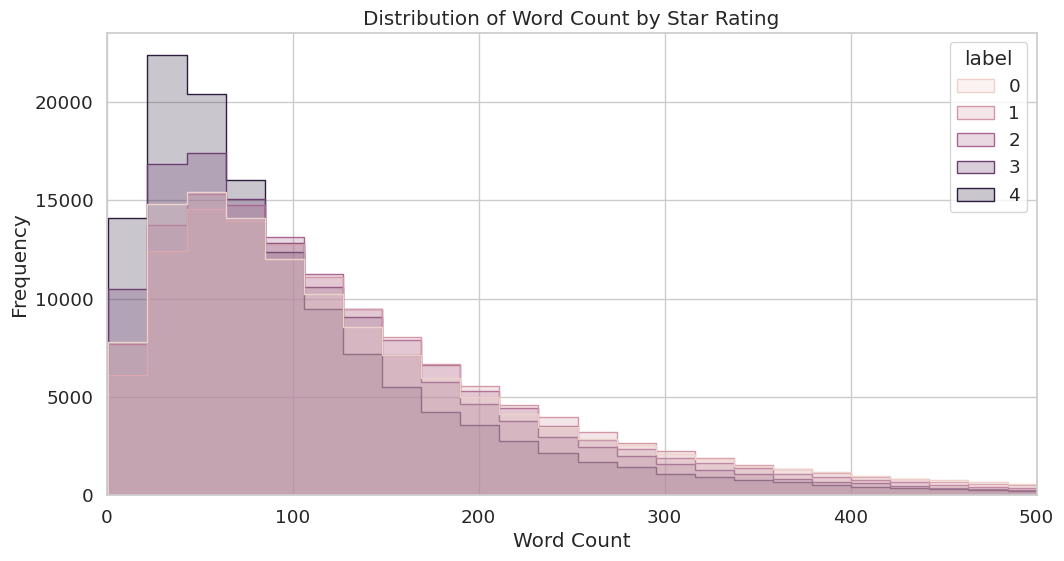

In [12]:
# 5. Text Length Analysis
print("\n--- Text Length Analysis ---")
train_df['text_length'] = train_df['text'].apply(len)

# Basic statistics on text length
print("Text length statistics (characters):")
print(train_df['text_length'].describe())

# Word count statistics
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
print("\nWord count statistics:")
print(train_df['word_count'].describe())

# Visualize text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='word_count', hue='label', bins=50, element='step')
plt.title('Distribution of Word Count by Star Rating')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 500)  # Focus on the main distribution
plt.show()


In [13]:
# 6. Sample Reviews from Each Category
print("\n--- Sample Reviews from Each Category ---")
for label in sorted(train_df['label'].unique()):
    print(f"\n--- {label} Star Rating Example ---")
    sample = train_df[train_df['label'] == label].sample(1)
    print(f"Review: {sample['text'].values[0][:300]}...")  # Show first 300 chars



--- Sample Reviews from Each Category ---

--- 0 Star Rating Example ---
Review: Pampas...or more like pompous.....my waiter was extremely pompous. His name was Andres. I wanted to try their 5.99 steak and eggs special because it was plastered all over the Miracle Mile Shops. However, it was really disappointing. I rarely ate meat these days and I was hoping it would be somewhat...

--- 1 Star Rating Example ---
Review: Ok, granted I came on one of the busiest shopping weekends of the year (Saturday after black Friday), but the place was a mess!  Clothes tossed everywhere.  They had a great deal on jeans, so I wanted to get a couple of pairs.  But it was almost impossible to find or even go through the display beca...

--- 2 Star Rating Example ---
Review: We've returned two years later, and I wasn't as WOWed. \n\nFirst of all, their texting waiting system? They don't tell you that it takes another hour PAST the waiting time printed on your ticket for you to be seated. My ticket time 


--- Word Cloud Analysis ---
Generating word clouds using 5000 reviews per rating...


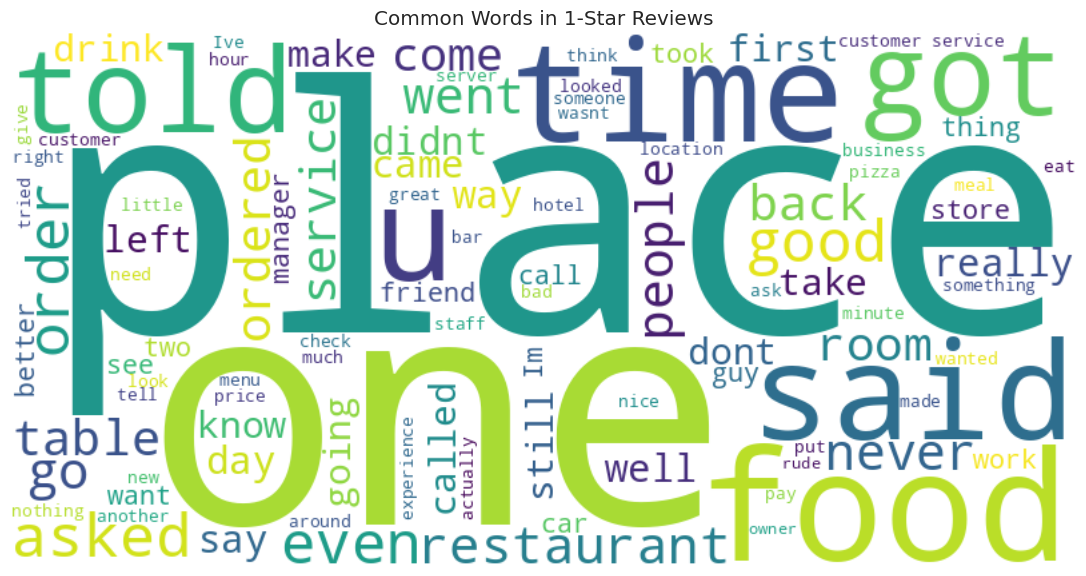

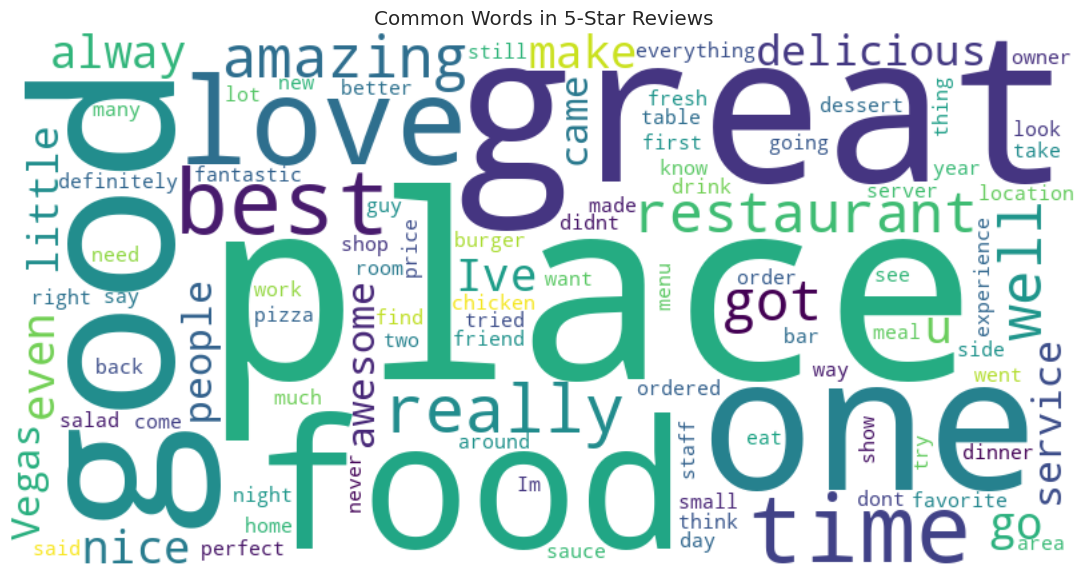

In [15]:
# 7. Word Cloud Analysis for each Star Rating
def generate_wordcloud(text, title):
    stop_words = set(stopwords.words('english'))
    # Clean text and remove stopwords
    words = ' '.join(text)
    words = re.sub(r'[^\w\s]', '', words)
    words = ' '.join([word for word in words.split() if word.lower() not in stop_words])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(words)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate word clouds for 1-star and 5-star reviews (extremes)
print("\n--- Word Cloud Analysis ---")
# Sample a subset for faster processing
sample_size = 5000
print(f"Generating word clouds using {sample_size} reviews per rating...")

generate_wordcloud(train_df[train_df['label'] == 0].sample(sample_size)['text'], 'Common Words in 1-Star Reviews')
generate_wordcloud(train_df[train_df['label'] == 4].sample(sample_size)['text'], 'Common Words in 5-Star Reviews')


--- Mapping to Sentiment Categories ---
Train set sentiment distribution:
sentiment
0    260000
1    130000
2    260000
Name: count, dtype: int64
Train set sentiment distribution (%): sentiment
0    40.0
1    20.0
2    40.0
Name: count, dtype: float64


/tmp/ipykernel_12761/3289267549.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=train_df, palette='RdYlGn')


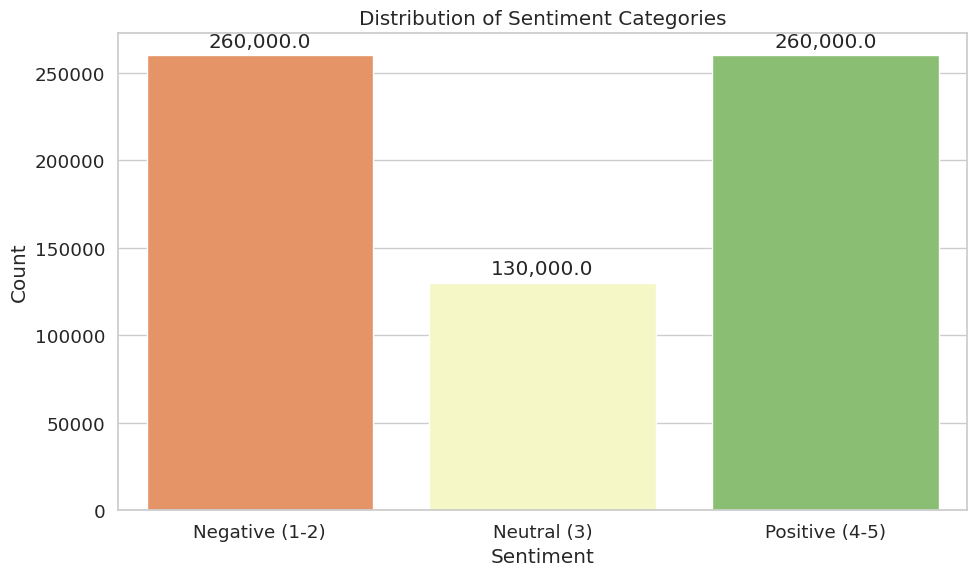

In [17]:
# 8. Map original ratings to sentiment categories for our project
print("\n--- Mapping to Sentiment Categories ---")
# For a 3-way classification:
# - 1-2 stars: Negative
# - 3 stars: Neutral
# - 4-5 stars: Positive
def map_to_sentiment(rating):
    if rating <= 1:
        return 0  # Negative
    elif rating == 2:
        return 1  # Neutral
    else:  # 4-5
        return 2  # Positive

train_df['sentiment'] = train_df['label'].apply(map_to_sentiment)
test_df['sentiment'] = test_df['label'].apply(map_to_sentiment)

# Show the distribution of sentiment categories
print("Train set sentiment distribution:")
sentiment_counts = train_df['sentiment'].value_counts().sort_index()
print(sentiment_counts)
sentiment_distribution = sentiment_counts / len(train_df) * 100
print(f"Train set sentiment distribution (%): {sentiment_distribution.round(2)}")

# Visualize sentiment distribution
sentiment_labels = ['Negative (1-2)', 'Neutral (3)', 'Positive (4-5)']
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment', data=train_df, palette='RdYlGn')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.xticks([0, 1, 2], sentiment_labels)
plt.ylabel('Count')

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.tight_layout()
plt.show()

In [18]:
# 9. Save processed data with sentiment labels
print("\n--- Saving Processed Data ---")
processed_dir = "../data/processed"
os.makedirs(processed_dir, exist_ok=True)

train_df.to_parquet(os.path.join(processed_dir, "train_with_sentiment.parquet"))
test_df.to_parquet(os.path.join(processed_dir, "test_with_sentiment.parquet"))
print(f"Saved processed data to {processed_dir}")



--- Saving Processed Data ---
Saved processed data to ../data/processed


In [ ]:
# 10. Summary of findings
print("\n--- Summary of Findings ---")
print(f"1. Dataset contains {len(train_df):,} training samples and {len(test_df):,} test samples")
print(f"2. Original labels are star ratings from 0-4, which we've mapped to 3 sentiment categories")
print(f"3. Average review length: {train_df['word_count'].mean():.1f} words")
print(f"4. Reviews range from {train_df['word_count'].min()} to {train_df['word_count'].max()} words")
print("5. Data appears to be balanced across star ratings")
print("6. Next steps: Preprocess text for LSTM and DistilBERT models")


--- Summary of Findings ---
1. Dataset contains 650,000 training samples and 50,000 test samples
2. Original labels are star ratings from 1-5, which we've mapped to 3 sentiment categories
3. Average review length: 134.1 words
4. Reviews range from 1 to 1052 words
5. Data appears to be balanced across star ratings
6. Next steps: Preprocess text for LSTM and DistilBERT models
